In [30]:
#Download BGC Argo Floats data


In [21]:
import polars as pl
import pandas as pd
import requests
import shutil
import os
import gzip
from pathlib import Path
import re
from tqdm import tqdm
from urllib.request import urlretrieve
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
host = 'https://data-argo.ifremer.fr/argo_synthetic-profile_index.txt'
dac = 'https://data-argo.ifremer.fr/dac'
data_directory = 'C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data'
filename = 'synth_file.txt'
destination = os.path.join(data_directory, filename)

In [66]:
response = requests.get(host, stream=True)

with open(destination, "wb") as f:
    r = requests.get(host)
    f.write(r.content)


In [12]:
index_table = pl.read_csv(destination, skip_rows=8)
index_table.height

306621

In [13]:
def extract_digits(text):
    match = re.search(r'\d+', text)
    return match.group() if match else 0

In [ ]:
# Mutate a new column based on the regular expression extraction
index_table = index_table.with_columns(
    pl.col('file').map_elements(lambda x: extract_digits(x), return_dtype=pl.Utf8).alias('wmo')
)
print(index_table)

In [22]:
wmo = '1902601'
wmo_table = index_table.filter(pl.col('wmo') == wmo)
wmo_table.height

51

In [49]:
local_argo_directory = data_directory + '/argo_nc'
wmo_directory = local_argo_directory + '/' + wmo
dac = 'https://data-argo.ifremer.fr/dac'
aux = 'https://data-argo.ifremer.fr/aux'
Path(wmo_directory).mkdir(parents=True, exist_ok=True)



In [ ]:
for i in tqdm(wmo_table['file']):
    download_url = dac + '/' + i
    filename = wmo_directory + '/' + download_url.rsplit('/', 1)[1]
    urlretrieve(download_url, filename)



In [ ]:
filename = 'C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/argo_nc/1902601/SR1902601_014.nc'
data = xr.open_dataset(filename)
data = data.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
display(data)

In [ ]:
#Scrap the list of the nc file in the aux directory
URL = aux + '/coriolis/1902601/profiles/'

tables = pd.read_html(URL) # Returns list of all tables on page
table = tables[0] # Select table of interest

In [44]:
#Format that table to remove na and non nc files
nc_table = table.dropna(subset=['Name'])
nc_table = nc_table[nc_table['Name'].str.endswith('.nc')]

In [61]:
print(wmo_directory + download_url.rsplit('/', 1)[1])

C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/argo_nc/1902601R1902601_005_aux.nc


In [63]:
for i in tqdm(nc_table['Name']):
    download_url = URL + '/' + i
    filename = wmo_directory + '/' + download_url.rsplit('/', 1)[1]
    urlretrieve(download_url, filename)

100%|██████████| 51/51 [02:52<00:00,  3.39s/it]


In [3]:
filename = 'C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/argo_nc/1902601/R1902601_020_aux.nc'
data = xr.open_dataset(filename)
data = data.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
display(data)

<xarray.Dataset> Size: 26MB
Dimensions:                                          (PROF_NUM: 7, N_PARAM: 12,
                                                      N_LEVELS: 1144,
                                                      N_VALUES18: 18,
                                                      N_VALUES5: 5,
                                                      N_VALUES40: 40,
                                                      N_VALUES70: 70,
                                                      N_HISTORY: 1, N_CALIB: 1)
Coordinates:
  * PROF_NUM                                         (PROF_NUM) float64 56B 2...
Dimensions without coordinates: N_PARAM, N_LEVELS, N_VALUES18, N_VALUES5,
                                N_VALUES40, N_VALUES70, N_HISTORY, N_CALIB
Data variables: (12/195)
    DATA_TYPE                                        object 8B ...
    FORMAT_VERSION                                   object 8B ...
    REFERENCE_DATE_TIME                              object 8B ...
    DATE_CREATION                                    object 8B ...
    DATE_UPDATE                                      object 8B ...
    PLATFORM_NUMBER                                  (PROF_NUM) object 56B ...
    ...                                               ...
    HISTORY_QCTEST                                   (N_HISTORY, PROF_NUM) object 56B ...
    PARAMETER                                        (PROF_NUM, N_CALIB, N_PARAM) object 672B ...
    SCIENTIFIC_CALIB_EQUATION                        (PROF_NUM, N_CALIB, N_PARAM) object 672B ...
    SCIENTIFIC_CALIB_COEFFICIENT                     (PROF_NUM, N_CALIB, N_PARAM) object 672B ...
    SCIENTIFIC_CALIB_COMMENT                         (PROF_NUM, N_CALIB, N_PARAM) object 672B ...
    SCIENTIFIC_CALIB_DATE                            (PROF_NUM, N_CALIB, N_PARAM) object 672B ...
Attributes:
    title:                Argo float vertical profile auxiliary data
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-03-05T09:13:47Z creation; 2024-03-05T09:13:47Z...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          CF-1.6 Coriolis-Argo-Aux-1.0
    featureType:          trajectoryProfileCoriolisAux
    decoder_version:      CODA_062c
    id:                   https://doi.org/10.17882/42182

In [4]:
ed = data['RAW_DOWNWELLING_IRRADIANCE']
df = ed.to_dataframe(name='value')

# Reset the index to make levels as a column
df_reset = df.reset_index()

# Create a unique identifier for each row
df_reset['index'] = df_reset.groupby('N_LEVELS').cumcount()

# Pivot the DataFrame
df_pivot = df_reset.pivot(columns='N_VALUES70', values='value')

In [5]:
df_reset.head()

,PROF_NUM,N_LEVELS,N_VALUES70,value,index
0,20.0,0,0,NaN,0
1,20.0,0,1,NaN,1
2,20.0,0,2,NaN,2
3,20.0,0,3,NaN,3
4,20.0,0,4,NaN,4


In [ ]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize=(12,6))
df_reset.plot('N_VALUES70', 'value', color=df_reset['N_LEVELS'], cmap=cmap)
plt.grid(alpha=0.5)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


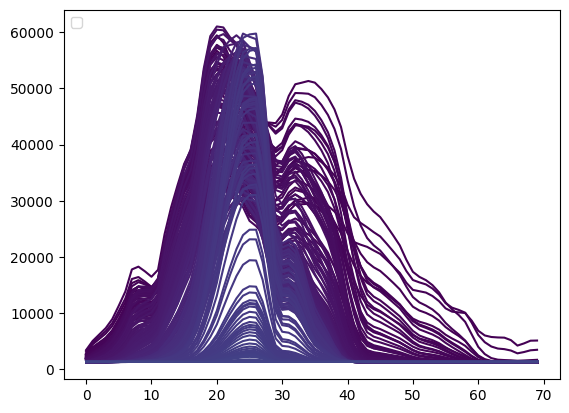

In [22]:
import numpy as np
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

for i in df_reset['N_LEVELS'].unique():
    dat = df_reset[df_reset['N_LEVELS'] == i]
    ax1.plot(dat['N_VALUES70'], dat['value'])

colormap = plt.colormaps['viridis'] #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
  

ax1.legend(loc=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


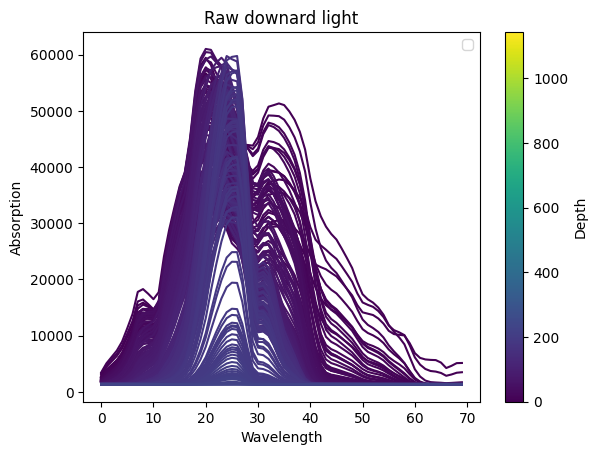

In [26]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Plotting
fig, ax = plt.subplots()

# Create a ScalarMappable for colormap
norm = Normalize(vmin=df_reset['N_LEVELS'].min(), vmax=df_reset['N_LEVELS'].max())
cmap = plt.get_cmap('viridis')  # You can choose any colormap you prefer
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# Plot each spectrum
for depth, group in df_reset.groupby('N_LEVELS'):
    ax.plot(group['N_VALUES70'], group['value'], color=cmap(norm(depth)))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Depth')

# Set labels and title
ax.set_xlabel('Wavelength')
ax.set_ylabel('Absorption')
ax.set_title('Raw downard light')

# Show legend
ax.legend()

plt.show()